Training Step: 1531  | total loss: 0.42305 | time: 44.409s
| Adam | epoch: 004 | loss: 0.42305 - acc: 0.8042 -- iter: 24448/24500
Training Step: 1532  | total loss: 0.42953 | time: 45.525s
| Adam | epoch: 004 | loss: 0.42953 - acc: 0.7972 | val_loss: 0.47311 - val_acc: 0.7560 -- iter: 24500/24500
--


100%|██████████| 12500/12500 [01:10<00:00, 176.10it/s]


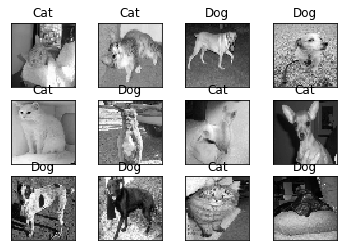

In [12]:
%matplotlib inline

import os
user = os.environ["HOME"]

# import numpy for numerical processing
import numpy as np

from random import shuffle

# import opencv for formatting data
import cv2

# simple progress bar for tasks
from tqdm import tqdm

# matplotlib for graphical plotting
import matplotlib

# import os to determine system config
import os

# call in data for train and test sets
TRAIN_DIR = user+"/Downloads/all/train"
TEST_DIR = user+"/Downloads/all/test"

# set image size (50x50)
IMG_SIZE = 50

# define learning rate as 0.001
LR = 1e-3

# name model for later use
MODEL_NAME = 'DOGSVSCATS-{}-{}.model'.format(LR, '2conv-basic')

# create functions to label images
def label_img(img):
    word_label=img.split('.')[-3]
    if word_label=='cat':return [1,0]
    elif word_label=='dog':return [0,1]

# create functions to preprocess training data
def create_training_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('training_data1.npy',training_data)
    return training_data

# function to preprocess test data
def process_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),np.array(img_num)])
    shuffle(testing_data)
    np.save('test_data.npy',testing_data)
    return testing_data


train_data = create_training_data()

# import machine learning module from tensorflow
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet,2,activation='softmax')
convnet = regression(convnet, optimizer='Adam', learning_rate=LR, loss='categorical_crossentropy',
                          name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


# set train data to be all but last 500 images in dataset
train = train_data[:-500]

# set test data to be last 500 data
test  = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input':X},{'targets':Y},n_epoch=4,validation_set=({'input':test_x},{'targets':test_y}),
          snapshot_step=50000,show_metric=True,run_id=MODEL_NAME)


import matplotlib.pyplot as plt
test_data = process_test_data()
fig = plt.figure()


for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()